In [2]:
! pip install pandas
! pip install matplotlib
! pip install seaborn

In [39]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [40]:
def directive(filename):
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('PROJECT_ID: '):
                value = line.split(':')[1].split('_')[0].strip()
                return value
    return None


In [42]:
import os
def load_data(df, machine):

    log_files = glob.glob(f'../results/{machine}/train/project/*/*.out')
    print(f"Output files found ({machine}):", len(log_files))
    # Iterate over each log file
    for log_file in log_files:
        with open(log_file, 'r') as file:
            for line in file:
                if '# csv,timer' in line:
                    header = line.strip().split(',')
                elif '# csv,total' in line:
                    line = line.strip().split(',')
                    # Create a dictionary with keys from header and values from line
                    data_dict = dict(zip(header, line))
                    # Delete specified keys from the dictionary
                    del data_dict['uname.node']
                    del data_dict['user']
                    del data_dict['uname.system']
                    del data_dict['platform.version']
                    del data_dict['msg']
                    del data_dict['start']
                    del data_dict['sum']
                    del data_dict['# csv']
                    del data_dict['status']
                    del data_dict['timer']
                    data_dict["machine"] = machine
                    d = directive(log_file)
                    data_dict["directive"] = d
                    data_dict["kind"] = f"{machine}-{d}"
                    # Append data_dict to df
                    df = pd.concat([df, pd.DataFrame(data_dict, index=[0])], ignore_index=True)


    df['time'] = df['time'].astype(float)
    return df

# machines = 
results_dir = '../results'
machines = [os.path.basename(file) for file in os.listdir(results_dir)]

df = pd.DataFrame()

for machine in machines:
    df = load_data(df, machine)  

df.loc[df['kind'] == 'ubuntu-None', 'kind'] = 'ubuntu-rtx3090'
df.loc[df['kind'] == 'macos-nometal-None', 'kind'] = 'macos-M1-Max-nometal'
df.loc[df['kind'] == 'macos-metal-None', 'kind'] = 'macos-M1-Max-metal'

df

Output files found (macos-metal): 3
Output files found (rivanna): 210
Output files found (macos-nometal): 3
Output files found (ubuntu): 3


,time,tag,machine,directive,kind
0,11.372,medium_cnn,macos-metal,None,macos-M1-Max-metal
1,41.430,large_tcnn,macos-metal,None,macos-M1-Max-metal
2,11.393,small_lstm,macos-metal,None,macos-M1-Max-metal
3,11.149,small_lstm,rivanna,rtx2080,rivanna-rtx2080
4,11.336,small_lstm,rivanna,rtx2080,rivanna-rtx2080
...,...,...,...,...,...
214,301.928,large_tcnn,macos-nometal,None,macos-M1-Max-nometal
215,3.304,small_lstm,macos-nometal,None,macos-M1-Max-nometal
216,6.150,small_lstm,ubuntu,None,ubuntu-rtx3090
217,8.453,medium_cnn,ubuntu,None,ubuntu-rtx3090


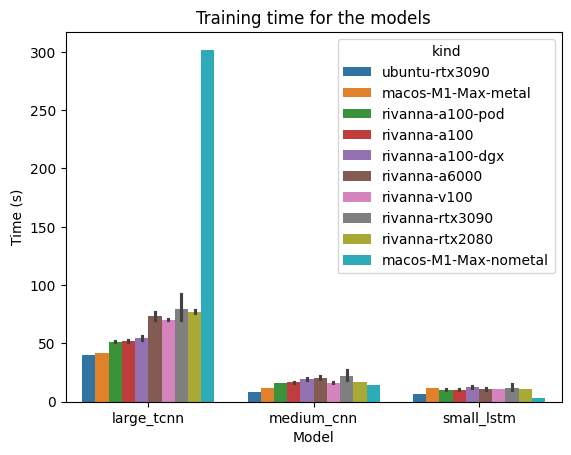

In [43]:
def plot_training_time(df):
    df_sorted = df.sort_values(['tag', 'time'])
    
    sns.barplot(x=df_sorted['tag'], y=df_sorted['time'], hue=df_sorted['kind'])

    plt.xlabel('Model')
    plt.ylabel('Time (s)')
    plt.title('Training time for the models')
    plt.show()

plot_training_time(df)


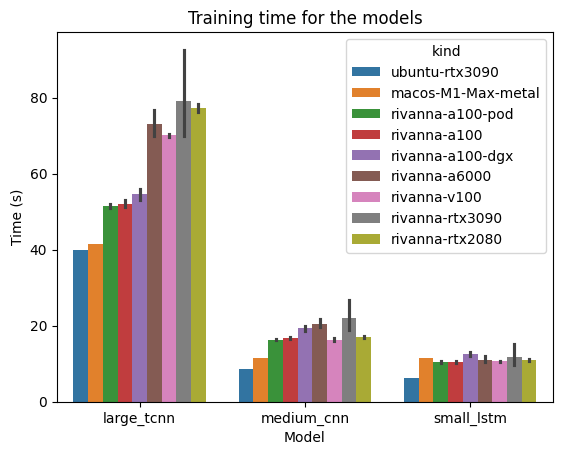

In [46]:
nomacos_df = df.query('machine != "macos-nometal"')

plot_training_time(nomacos_df)